<a href="https://colab.research.google.com/github/pro-trice8/Fake-News-Detection/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings("ignore")
import os

fake = pd.read_csv('/content/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [2]:
true = pd.read_csv('/content/True.csv')
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
true['label'] = 1
fake['label'] = 0

In [4]:
df = pd.concat([true, fake], ignore_index=True)

In [5]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
print(f"Shape: {df.shape}")

Shape: (44898, 5)


In [8]:
df['label'].value_counts()

,count
label,
0,23481
1,21417


In [9]:
df = df[['title', 'text', 'label']]
df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [10]:
df.isnull().sum()
df.dropna()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [11]:
df['content'] = df['title'] + ' ' + df['text']

In [12]:
df = df[["content", "label"]]
df.head()

,content,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(words)

In [18]:
df["clean_text"] = df["content"].apply(clean_text)

In [17]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [19]:
df.head()

,content,label,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",1,u budget fight loom republican flip fiscal scr...
1,U.S. military to accept transgender recruits o...,1,u military accept transgender recruit monday p...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1,senior u republican senator let mr mueller job...
3,FBI Russia probe helped by Australian diplomat...,1,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,1,trump want postal service charge much amazon s...


In [20]:
real_text = " ".join(df[df["label"] == 1]["clean_text"])
fake_text = " ".join(df[df["label"] == 0]["clean_text"])

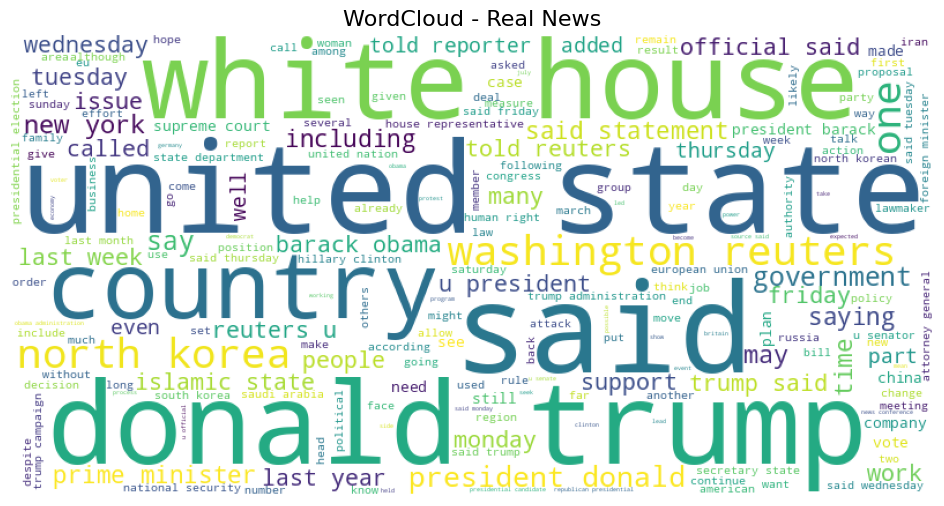

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.figure(figsize=(12,6))
plt.title("WordCloud - Real News", fontsize=16)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(real_text))
plt.axis("off")
plt.show()

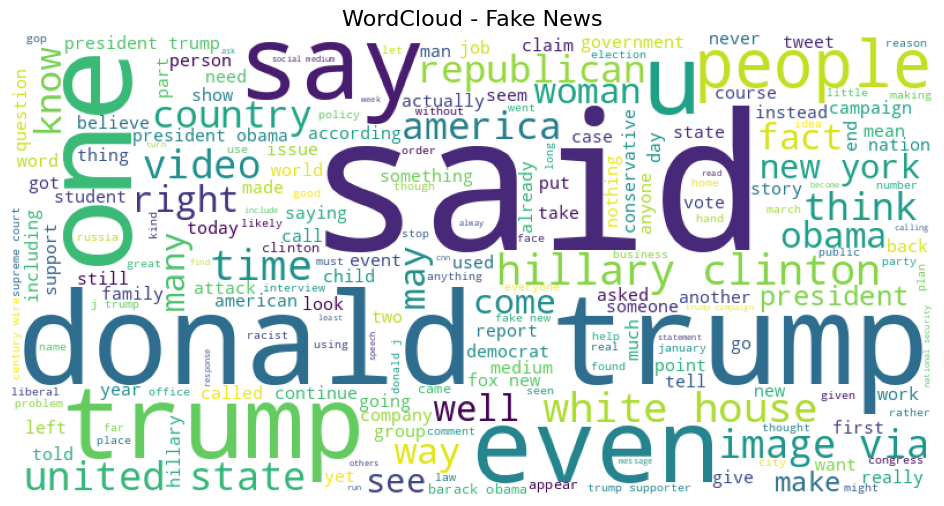

In [22]:
plt.figure(figsize=(12,6))
plt.title("WordCloud - Fake News", fontsize=16)
plt.imshow(WordCloud(width=800, height=400, background_color="white").generate(fake_text))
plt.axis("off")
plt.show()

In [23]:
df["text_length"] = df["clean_text"].apply(lambda x: len(x.split()))

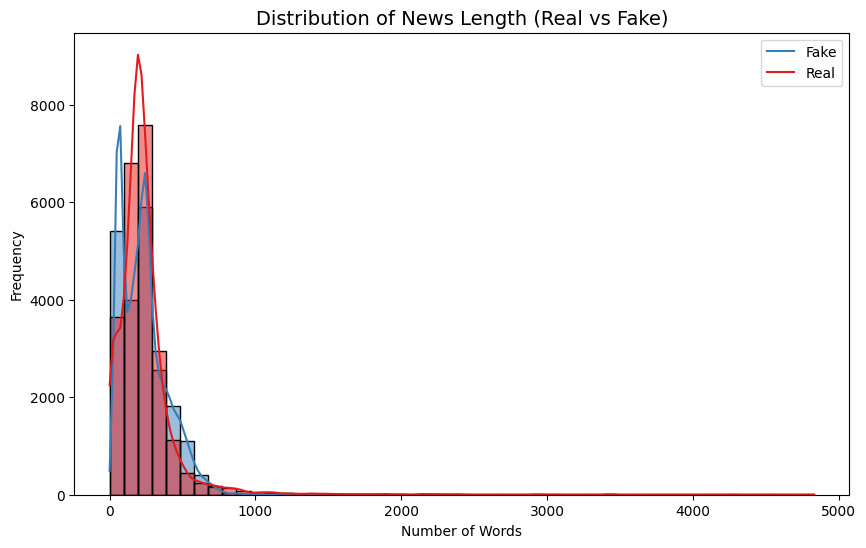

In [24]:
#Visualization
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="text_length", hue="label", bins=50, kde=True, palette="Set1")
plt.title("Distribution of News Length (Real vs Fake)", fontsize=14)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(["Fake", "Real"])
plt.show()

In [25]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X = tfidf.fit_transform(df["clean_text"])
y = df["label"]

print("TF-IDF shape:", X.shape)

TF-IDF shape: (44898, 5000)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (35918, 5000)
Test size: (8980, 5000)


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": LinearSVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

Training model: Logistic Regression

 Accuracy of Logistic Regression: 0.9896
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4650
        Real       0.99      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



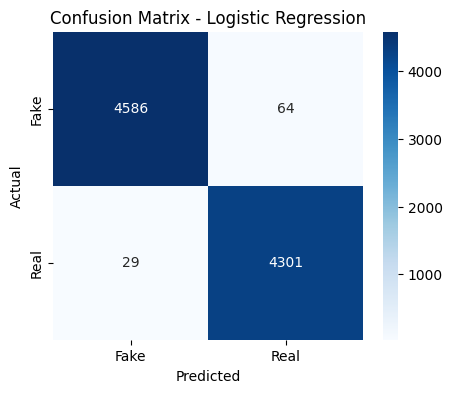

Training model: Naive Bayes

 Accuracy of Naive Bayes: 0.9450
              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4650
        Real       0.94      0.94      0.94      4330

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



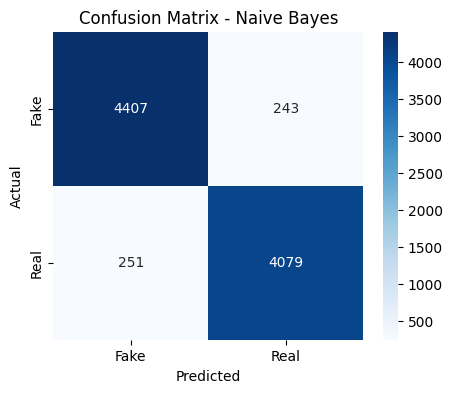

Training model: Random Forest

 Accuracy of Random Forest: 0.9978
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4650
        Real       1.00      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



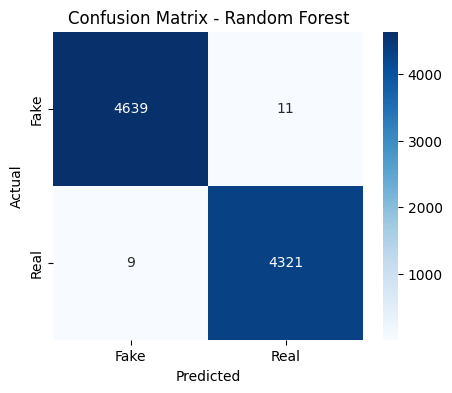

Training model: SVM

 Accuracy of SVM: 0.9952
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4650
        Real       0.99      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



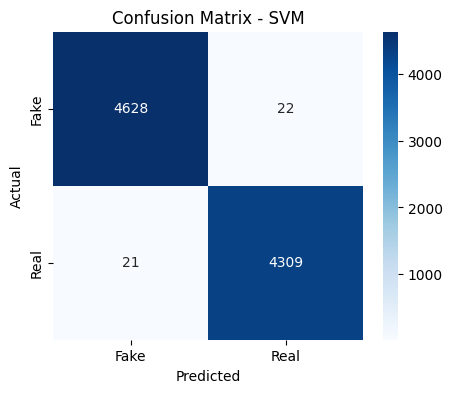

Training model: Gradient Boosting

 Accuracy of Gradient Boosting: 0.9959
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4650
        Real       0.99      1.00      1.00      4330

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



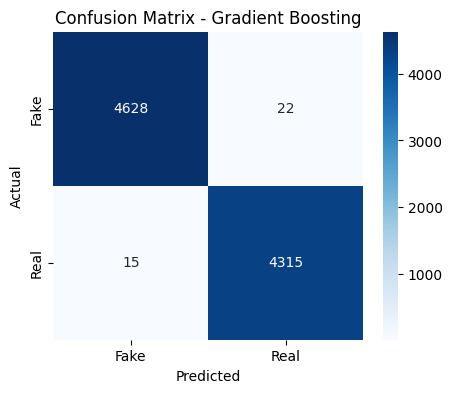

In [30]:
results = []

for name, model in models.items():
    print(f"Training model: {name}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n Accuracy of {name}: {acc:.4f}")

    # Print classification report
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

    # Store result
    results.append((name, acc))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [31]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

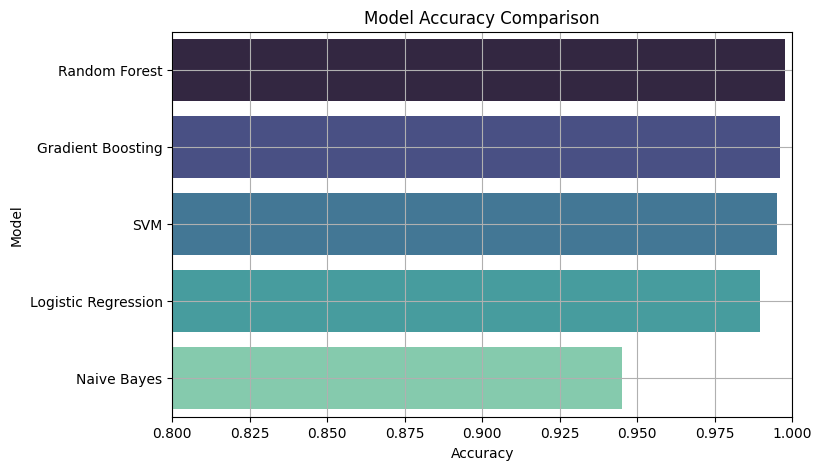

In [32]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="mako")
plt.title("Model Accuracy Comparison")
plt.xlim(0.8, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.grid(True)
plt.show()

In [33]:
results_df

,Model,Accuracy
2,Random Forest,0.997773
4,Gradient Boosting,0.995880
3,SVM,0.995212
0,Logistic Regression,0.989644
1,Naive Bayes,0.944989


In [35]:
def output_label(n):
  if n==0:
    return "Fake News"
  elif n==1:
    return "True News"

def manual_testing(news):
  testing_news = {"text":[news]}
  new_def_test = pd.DataFrame(testing_news)
  new_def_test["clean_text"] = new_def_test["text"].apply(clean_text)
  new_x_test = new_def_test["clean_text"]
  new_xv_test = tfidf.transform(new_x_test)
  pred_LR = models["Logistic Regression"].predict(new_xv_test)
  pred_NB = models["Naive Bayes"].predict(new_xv_test)
  pred_RF = models["Random Forest"].predict(new_xv_test)
  pred_SVM = models["SVM"].predict(new_xv_test)
  pred_GB = models["Gradient Boosting"].predict(new_xv_test)

  return print("\n\nLR Prediction: {} \nNB Prediction: {} \nRF Prediction: {} \nSVM Prediction: {} \nGB Prediction: {}".format(output_label(pred_LR[0]), output_label(pred_NB[0]), output_label(pred_RF[0]), output_label(pred_SVM[0]), output_label(pred_GB[0])))


In [38]:
news = str(input())
manual_testing(news)

Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing


LR Prediction: Fake News 
NB Prediction: Fake News 
RF Prediction: Fake News 
SVM Prediction: Fake News 
GB Prediction: Fake News
